### Setup

In [2]:
import pandas as pd
import numpy as np
import scipy as sp
from Bio import SeqIO, Align

from sklearn import preprocessing

import matplotlib.pyplot as plt
import seaborn as sns
import pickle as pkl

import sys
sys.path.insert(0,'/fast/AG_Ohler/frederick/projects/mlcis/utils')

seed = 42
np.random.seed(seed)

In [3]:
def onehot_var(df, col='five_utr',seq_len=50):
    '''
    takes a column of a param:df specified in param:col and one-hot encodes the dna sequence entries
    into one-hot matrices of equal dimension. Pads to param:seq_len if sequences are shorter than param:seq_len.
    '''
    nuc_d = {'a':[1,0,0,0],'c':[0,1,0,0],'g':[0,0,1,0],'t':[0,0,0,1], 'n':[0,0,0,0]}
    vectors=np.empty([len(df),seq_len,4])

    for i,seq in enumerate(df[col].str[:seq_len]): 
        
        seq=seq.lower()
        vec=np.array([nuc_d[x] for x in seq])
        
        while vec.shape[0]<seq_len:
            vec=np.vstack((vec,np.zeros(4)))
    
        vectors[i]=vec

    return vectors

    
    
def r2(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue**2, 4)

def r(x,y):
    res = sp.stats.linregress(x, y)
    return round(res.rvalue, 4)


def match_pairwise(x, col_x = 'utr', threshold = 40):
    a = x[col_x].to_numpy()
    b = utr_data['five_utr'].to_numpy()
    score_dict = {}

    aligner = Align.PairwiseAligner()
    aligner.open_gap_score = -5
    aligner.extend_gap_score = 0
    
    for i,seq1 in enumerate(a):
        for j,seq2 in enumerate(b):
            score = aligner.score(seq1, seq2[-100:])
            if score > threshold:
                #if i not in [key[0] for key in score_dict.keys()]:
                score_dict[(i,j)] = (seq1,seq2)

    return score_dict


def make_pairs_df(mpra_df, ribo_df, score_dict):
    
    merged_rows = []
    
    for (id1, id2), (seq1, seq2) in score_dict.items():

        #get rows correspondig to indices from original dataframes
        mpra = mpra_df.iloc[id1].copy()
        ribo = ribo_df.iloc[id2].copy()

        #add dataframe identifier to each column
        mpra = mpra.rename(lambda x: f"{x}_mpra")
        ribo = ribo.rename(lambda x: f"{x}_ribo")

        #concatenate columns
        merged_row = pd.concat([mpra,ribo])

        #make list of merged rows
        merged_rows.append(merged_row)


    #create df from list of merged rows
    return pd.DataFrame(merged_rows)
        

### Preprocessing

First, we will preprocess Ribo-Seq data obtained from the orfquant paper (https://doi.org/10.1038/s41594-020-0450-4)
1. Choose all transcripts with ORFs_pM > 1
3. Choose all genes with RNAseq TPM > 1
4. Merge rpf df, rna df and sequence df via transcript id
5. There are multiple ORFs per transcript. Choose ORF with highest ORFs_pM value per gene.
6. Calculate TE by dividing the normalized read counts. Perform log2-transform of the resulting TE values.

Questions
- How can I retain more entries in the final dataframe? How many entries does framepool have per dataset?

#### Data Import and Merging

In [4]:
#import the rpf orfpm counts
rpf = pd.read_csv('hek-orfquant-orfpm.tsv', sep='\t')[['transcript_id', 'gene_id', 'gene_name', 'region.start', 'region.end','ORFs_pM']]

#keep ORF with highest ORFs_pM per gene
len_before = len(rpf)


#keep only ORFs with ORFs_pM > 1
rpf = rpf[rpf['ORFs_pM']>=1].reset_index(drop=True)
len_after_1 = len(rpf)

print('Before removal of multiple transcripts per gene: '+str(len_before))
print('After keeping only transcripts with ORFs_pM > 1: '+str(len_after_1))

Before removal of multiple transcripts per gene: 20816
After keeping only transcripts with ORFs_pM > 1: 18939


In [5]:
#import the rnaseq tpm counts
rna = pd.read_csv('hek-rnaseq-tpm.tsv',sep='\t')
bef_len = len(rna)

#remove transcripts with tpm<1
rna = rna[rna['tpm']>1]
aft_len = len(rna)

#rename target_id column to transcript_id
rna = rna.rename(columns={'target_id':'transcript_id'})

print('Before removal of any transcripts: '+str(bef_len))
print('After keeping only transcripts with TPM > 1: '+str(aft_len))

Before removal of any transcripts: 198093
After keeping only transcripts with TPM > 1: 27351


Extract the 5'UTR sequences corresponding to each transcript. Add them as new column to the merged dataframe using transcript ID as link. After that, collapse to gene level using highest ORFs_pM per gene.

In [6]:
#import the 5utr sequences from fasta (extracted from hg38 release 25 annotation) and make dataframe
seq_ids = []
seqs = []

for seq in SeqIO.parse('5utrs.fa', 'fasta'):
    seq_ids.append(str(seq.id))
    seqs.append(str(seq.seq))

utr = pd.DataFrame({'transcript_id':seq_ids, 'five_utr':seqs})

print('There are '+str(len(utr))+' 5utrs in the utr dataframe before merging rpf and rnaseq.')

There are 78899 5utrs in the utr dataframe before merging rpf and rnaseq.


In [7]:
#merge all three dataframes on transcript_id column

#rpf+ rna
te_data = rpf.merge(rna, on='transcript_id')
print('There are '+str(len(te_data))+' left after merging rpf and rnaseq.')

#add 5utr sequences
utr_data = te_data.merge(utr, on='transcript_id')

print('There are '+str(len(utr_data))+' entries in the final dataframe.')

There are 10433 left after merging rpf and rnaseq.
There are 9419 entries in the final dataframe.


In [8]:
#collapse to gene level; keep transcript with highest ORFs_pM count per gene
utr_data = utr_data.sort_values('ORFs_pM', ascending=False).drop_duplicates('gene_id').sort_index()
len_after = len(utr_data)
print('After keeping only the transcript with highest ORFs_pM per gene: '+str(len_after))

After keeping only the transcript with highest ORFs_pM per gene: 7663


In [16]:
#utr_data.to_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/riboseq/calviello_te_processed.csv')

#### Calculate Translation Efficiencies

In [9]:
#make column for translation efficiencies
utr_data['TE'] = utr_data['ORFs_pM']/utr_data['tpm']

#add column with log2-transformed TEs
utr_data['log2TE'] = np.log2(utr_data['TE'])



[(-5.0, 15.0)]

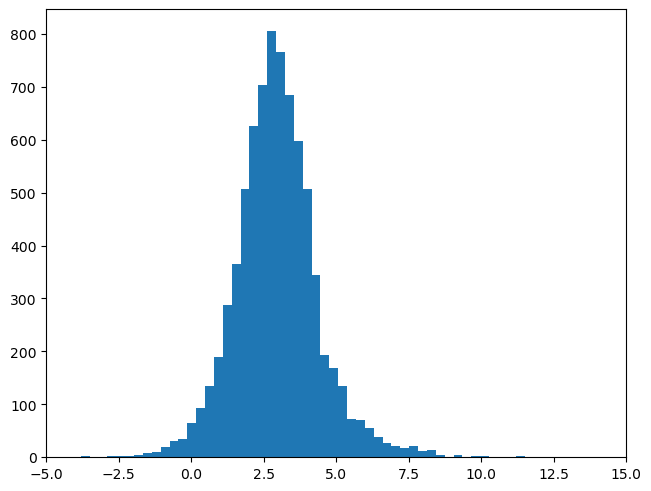

In [10]:
f, ax1 = plt.subplots(ncols=1, layout='constrained')
ax1.hist(utr_data.log2TE, bins=50)
ax1.set(xlim=(-5,15))


### Correlating TE x MRL after Pairwise Alignment

1. Load both MRL datasets
2. compute pairwise alignment for sequences from each MPRA dataset with transcripts from the TE dataset (allow multiple matches to account for isoforms)
3. make one dataframe per correlation for matched sequences pairs and associated MRL/TE to plot

Questions
Does correlation of MPRA data with Riboseq-TEs yield higher correlation for matching by pairwise alignment rather than trascript ID?
    - Yes, correlation after matching by transcript IDs derived from STAR alignment leads to pairs with different sequences


In [11]:
mrl25to100 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/mrl25to100/GSM4084997_varying_length_25to100.csv').drop('Unnamed: 0', axis=1)
mrl25to100 = mrl25to100.loc[mrl25to100.set == 'human']
mrl25to100 = mrl25to100.loc[mrl25to100.total_reads >= 10 ]  #select reporters with most reads similar to Sample et. al
mrl25to100 = mrl25to100.sort_values('total', ascending = False).reset_index(drop = True)

mrl50 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/mrl25to100/GSM3130443_designed_library.csv').drop('Unnamed: 0', axis=1)
mrl50 = mrl50[(mrl50['library'] == 'human_utrs') | (mrl50['library'] == 'snv')]
mrl50 = mrl50.sort_values('total', ascending = False).reset_index(drop = True).iloc[:25000] #select reporters with most reads

/tmp/ipykernel_299397/415521373.py:6: DtypeWarning: Columns (33,34,35,36,37) have mixed types. Specify dtype option on import or set low_memory=False.
  mrl50 = pd.read_csv('/fast/AG_Ohler/frederick/projects/mlcis/data/mrl25to100/GSM3130443_designed_library.csv').drop('Unnamed: 0', axis=1)


#### Compute Pairwise Alignment of MRL50 and MRL25to100 with TE sequences

In [17]:
#score_mrl50_calviello = match_pairwise(mrl50)

with open('score_mrl50_calviello.pkl', 'rb') as f:
    score_mrl50_calviello = pkl.load(f)

In [21]:
#score_mrl25to100_calviello = match_pairwise(mrl25to100)

with open('score_mrl25to100_calviello.pkl', 'rb') as f:
    score_mrl25to100_calviello = pkl.load(f)

In [23]:
# merge mrl50 with utr_data at positions from score_mrl50_TE to get sequence pairs and associated experimental values
mpra50_ribo_pairs = make_pairs_df(mrl50, utr_data, score_mrl50_calviello)
#['utr','rl','id']
# same for mrl25to100
mpra25to100_ribo_pairs = make_pairs_df(mrl25to100, utr_data, score_mrl25to100_calviello)
#['transcript_id','gene_id','gene_name','ORFs_pM','length','tpm','five_utr','TE','log2TE']

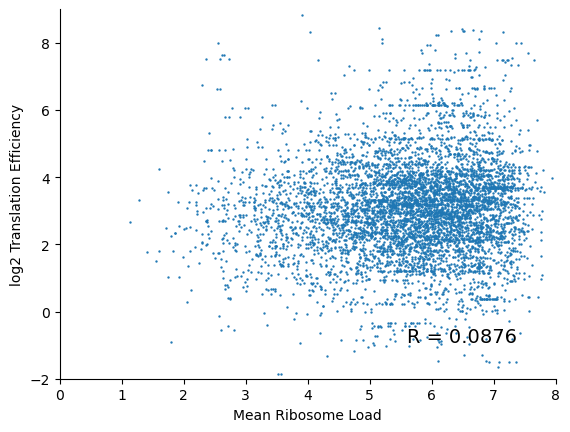

In [71]:
t, ax = plt.subplots()
plt.setp(ax, xlim=(0,8), ylim=(-2,9))
ax.set_ylabel('log2 Translation Efficiency')
ax.set_xlabel('Mean Ribosome Load')

#utrs between 45 and 55 nts in length
ax.scatter(mpra50_ribo_pairs['rl_mpra'],mpra50_ribo_pairs['log2TE_ribo'], s=0.5)
ax.annotate('R = %s' % r(mpra50_ribo_pairs['rl_mpra'],mpra50_ribo_pairs['log2TE_ribo']),xy=(0.7, 0.1),xycoords='axes fraction',fontsize=14)

ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

In [74]:
len(mpra50_ribo_pairs)

6100

In [73]:
t.savefig('/fast/AG_Ohler/frederick/projects/mlcis/data/riboseq/mrl50_te_correlation.pdf')